In [1]:
import pandas as pd
import pickle
from itertools import permutations
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [2]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/src/trained_models/final_model.pkl', 'rb') as f:
    r_model = pickle.load(f)

with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/src/trained_models/final_classification_model.pkl', 'rb') as f:
    c_model = pickle.load(f)

In [4]:
X_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/X_train_val.csv')
y_train = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/y_train_val.csv').iloc[:, 0]

X_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/X_test.csv')
y_test = pd.read_csv('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/database/model_input/y_test.csv').iloc[:, 0]

y_train_pred_r = r_model[516].predict(X_train).round(1)
y_train_pred_c = c_model[516].predict(X_train)
y_test_pred_r = r_model[516].predict(X_test).round(1)
y_test_pred_c = c_model[516].predict(X_test)

In [5]:
y_train.value_counts()

target
0.5    1117
0.4    1117
0.3    1117
0.6    1117
0.2    1032
0.7    1032
0.8    1032
0.1     947
0.9     947
0.0     796
1.0     795
Name: count, dtype: int64

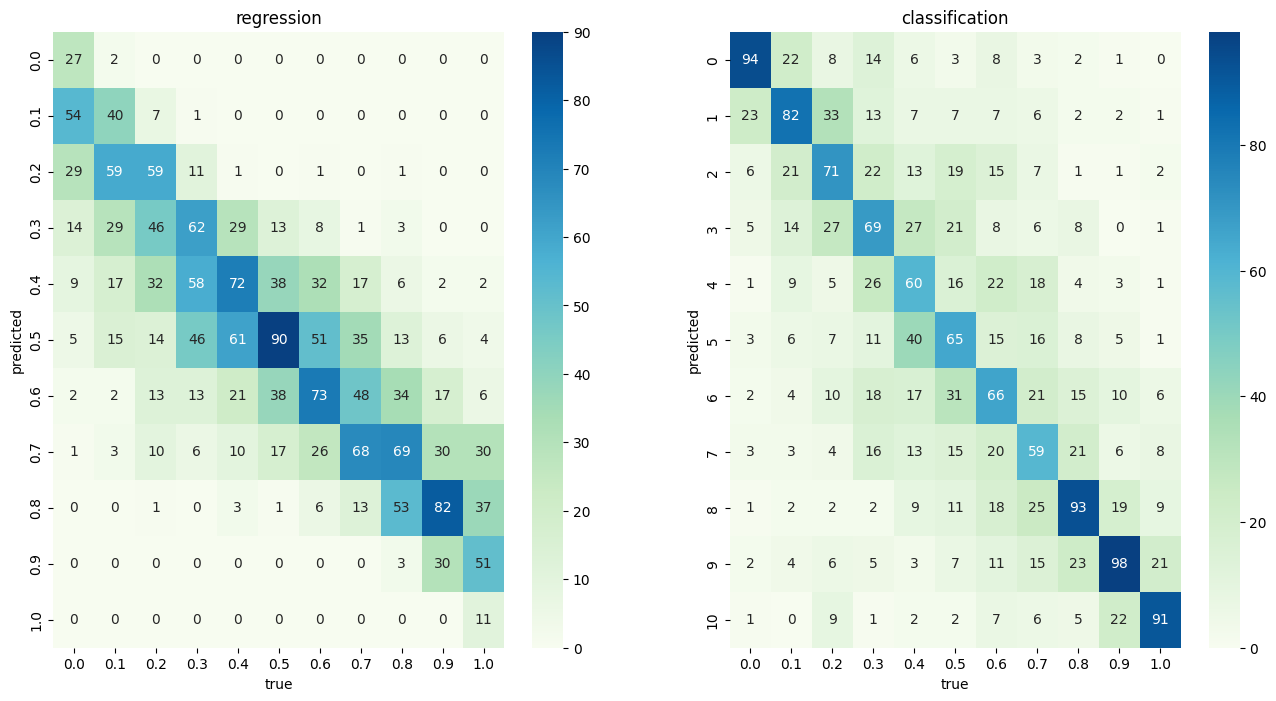

In [11]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
sns.heatmap(pd.crosstab(pd.Series(y_test_pred_r, name='predicted'), pd.Series(np.array(y_test), name='true')), 
                    annot=True, 
                    cmap='GnBu',
                    ax=ax[0]);
ax[0].set_title('regression')
sns.heatmap(pd.crosstab(pd.Series(y_test_pred_c, name='predicted'), pd.Series(np.array(y_test), name='true')), 
            annot=True, 
            cmap='GnBu',
            ax=ax[1]);
ax[1].set_title('classification')
plt.show()

In [12]:
elements = list(range(10))
dispositions = list(permutations(elements, 4))

splits = pd.DataFrame(np.sort(dispositions)).drop_duplicates()

def discretise(val, partition):
    if val <= partition[0]:
        return 0
    elif val <= partition[1]:
        return 1
    elif val <= partition[2]:
        return 2
    elif val <= partition[3]:
        return 3
    elif val <= 10:
        return 4

In [13]:
results = {key: [] for key in ['train_r', 'train_c', 'test_r', 'test_c']}

for idx in tqdm(splits.index, desc='Running splits...'):
    for n, (y_pred, y_true) in enumerate(zip([pd.Series(y_train_pred_r, name='target_encoded'), 
                                              pd.Series(y_train_pred_c, name='target_encoded'), 
                                              pd.Series(y_test_pred_r, name='target_encoded'), 
                                              pd.Series(y_test_pred_c, name='target_encoded')], 
                                              [y_train, y_train, y_test, y_test])):
        env = list(results.keys())[n]
        pred = y_pred.apply(lambda x: discretise(x, splits.loc[idx, :]))
        true = y_true.apply(lambda x: discretise(x, splits.loc[idx, :]))

        score = accuracy_score(pred, true)
        results[env].append(score)

with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/outputs/grid_searches/discretisations.pkl', 'wb') as f:
    pickle.dump(results, f)


Running splits...:   0%|          | 0/210 [00:00<?, ?it/s]

Running splits...: 100%|██████████| 210/210 [07:46<00:00,  2.22s/it]


In [21]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/outputs/grid_searches/discretisations.pkl', 'wb') as f:
    pickle.dump(results, f)

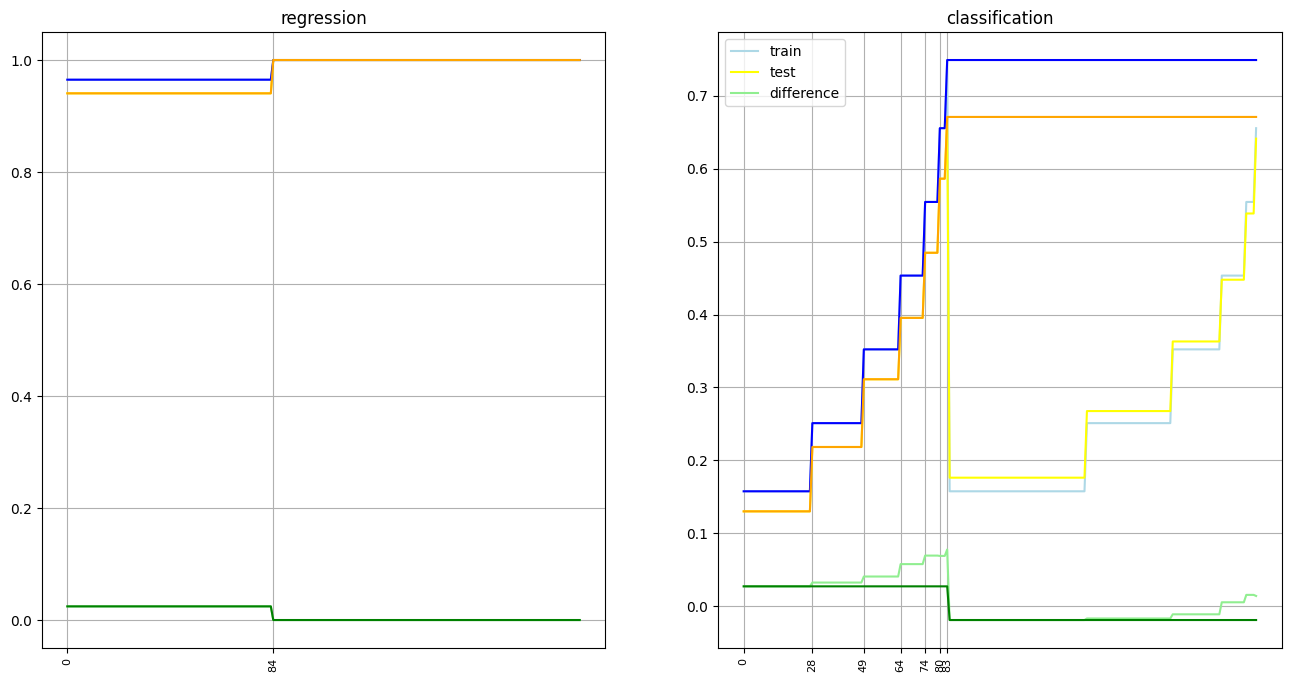

<Figure size 640x480 with 0 Axes>

In [36]:
with open('/nfs/home/genovese/thesis-wildfire-genovese/rekriging_target/resampling/outputs/grid_searches/discretisations.pkl', 'rb') as f:
    results = pickle.load(f)

fig, ax = plt.subplots(1,2, figsize=(16,8))

ax[0].plot(range(splits.shape[0]), results['train_r'], color='lightblue', label='train')
ax[0].plot(range(splits.shape[0]), results['test_r'], color='yellow', label='test')
ax[0].plot(range(splits.shape[0]), np.array(results['train_r']) - np.array(results['test_r']), color='lightgreen', label='difference')
ax[0].plot(range(splits.shape[0]), [np.max(results['train_r'][:n+1]) for n in range(splits.shape[0])], color = 'blue')
ax[0].plot(range(splits.shape[0]), [np.max(results['test_r'][:n+1]) for n in range(splits.shape[0])], color = 'orange')
ax[0].plot(range(splits.shape[0]), [np.min((np.array(results['train_r']) - np.array(results['test_r']))[:n+1]) for n in range(splits.shape[0])], color = 'green')
mask = ~pd.Series([np.max(results['train_r'][:n+1]) for n in range(splits.shape[0])]).duplicated()
ax[0].set_xticks(pd.Series([np.max(results['train_r'][:n+1]) for n in range(splits.shape[0])]).loc[mask].index)
ax[0].tick_params('x', labelrotation = 90, labelsize=8)
ax[0].grid(True)
ax[0].set_title('regression')

thresholds_r = [int(tick.get_text()) for tick in ax[0].get_xticklabels()]

ax[1].plot(range(splits.shape[0]), results['train_c'], color='lightblue', label='train')
ax[1].plot(range(splits.shape[0]), results['test_c'], color='yellow', label='test')
ax[1].plot(range(splits.shape[0]), np.array(results['train_c']) - np.array(results['test_c']), color='lightgreen', label='difference')
ax[1].plot(range(splits.shape[0]), [np.max(results['train_c'][:n+1]) for n in range(splits.shape[0])], color = 'blue')
ax[1].plot(range(splits.shape[0]), [np.max(results['test_c'][:n+1]) for n in range(splits.shape[0])], color = 'orange')
ax[1].plot(range(splits.shape[0]), [np.min((np.array(results['train_c']) - np.array(results['test_c']))[:n+1]) for n in range(splits.shape[0])], color = 'green')
mask = ~pd.Series([np.max(results['train_c'][:n+1]) for n in range(splits.shape[0])]).duplicated()
ax[1].set_xticks(pd.Series([np.max(results['train_c'][:n+1]) for n in range(splits.shape[0])]).loc[mask].index)
ax[1].tick_params('x', labelrotation = 90, labelsize=8)
ax[1].grid(True)
ax[1].set_title('classification')
thresholds_c = [int(tick.get_text()) for tick in ax[1].get_xticklabels()]
plt.legend()

plt.show()



plt.clf()

In [37]:
splits.iloc[thresholds_r, ]

,0,1,2,3
0,0,1,2,3
568,1,2,3,4


In [38]:
splits.iloc[thresholds_c, ]

,0,1,2,3
0,0,1,2,3
64,0,2,3,4
128,0,3,4,5
192,0,4,5,6
256,0,5,6,7
320,0,6,7,8
384,0,7,8,9
